### Importing Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

'''
The "punkt" package consists in unsafe pickles, so it is deprecated and not used in NLTK 3.8.2. 
It is replaced by "punkt_tab". Users should definitively avoid the highly toxic pickle vulnerability, and upgrade to NLTK 3.8.2.
'''

# nltk.download('punkt')
nltk.download('punkt_tab') # Tokenization
nltk.download('wordnet') # Lemmatization
nltk.download('stopwords') # Stopwords
nltk.download('averaged_perceptron_tagger_eng') # POS tagging

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer # Text Vectoization

# For Model Building
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\utsav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\utsav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utsav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\utsav\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [5]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [6]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

### Data Visualization

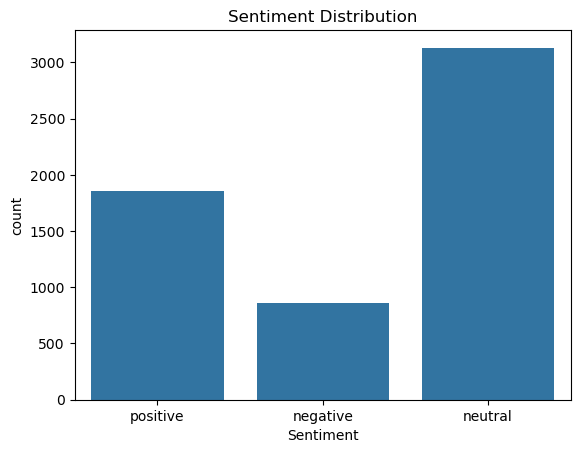

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64


In [7]:
sns.countplot(x=df.Sentiment)
plt.title('Sentiment Distribution')
plt.show()

print(df.Sentiment.value_counts())

In [8]:
print("No. of Duplicates: ",df.duplicated().sum())

No. of Duplicates:  6


In [9]:
df = df.drop_duplicates(keep='first')

In [10]:
print("No. of Duplicates: ",df.duplicated().sum())

No. of Duplicates:  0


In [11]:
df.Sentiment.value_counts()

Sentiment
neutral     3124
positive    1852
negative     860
Name: count, dtype: int64

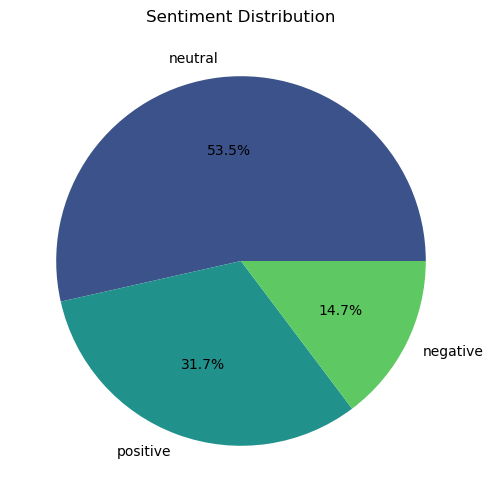

In [12]:
# Sentiment Distribution as Pie Chart
sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(sentiment_counts)))
plt.title('Sentiment Distribution')
plt.show()

#### Inference from Data Visualization: 

Can clearly see data imbalance, can be solved using Resampling, BalancedBaggingClassifier, SMOTE (Synthetic Minority Oversampling Technique), etc...

### Text Preprocessing

In [13]:
def preprocess_text(text):

    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    # Remove stop words
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Apply stemming and lemmatization
    stems = [stemmer.stem(token) for token in tokens]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return stems, lemmas

# Unpacking list of tuples and then apply the preprocessing function to the DataFrame
df['tokens'], df['lemmas'] = zip(*df['Sentence'].apply(preprocess_text))  

In [14]:
df.head()

,Sentence,Sentiment,tokens,lemmas
0,The GeoSolutions technology will leverage Bene...,positive,"[geosolut, technolog, leverag, benefon, 's, gp...","[GeoSolutions, technology, leverage, Benefon, ..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[$, esi, low, ,, $, 1.50, $, 2.50, bk, real, p...","[$, ESI, low, ,, $, 1.50, $, 2.50, BK, real, p..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[last, quarter, 2010, ,, componenta, 's, net, ...","[last, quarter, 2010, ,, Componenta, 's, net, ..."
3,According to the Finnish-Russian Chamber of Co...,neutral,"[accord, finnish-russian, chamber, commerc, ,,...","[According, Finnish-Russian, Chamber, Commerce..."
4,The Swedish buyout firm has sold its remaining...,neutral,"[swedish, buyout, firm, sold, remain, 22.4, pe...","[Swedish, buyout, firm, sold, remaining, 22.4,..."


### Text Analysis

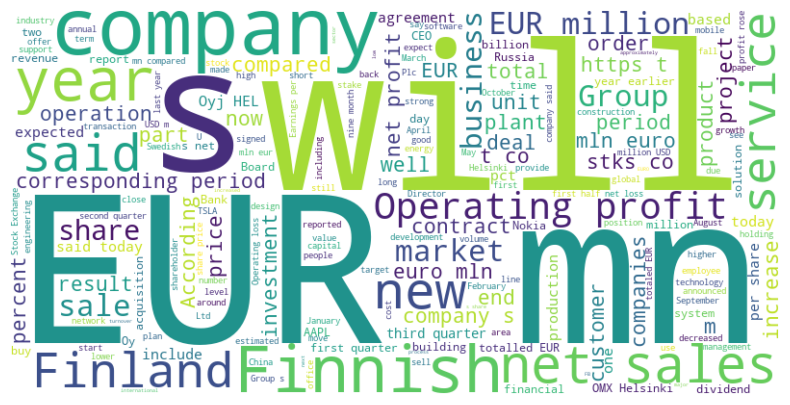

In [15]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_wordcloud(' '.join(df['Sentence']))

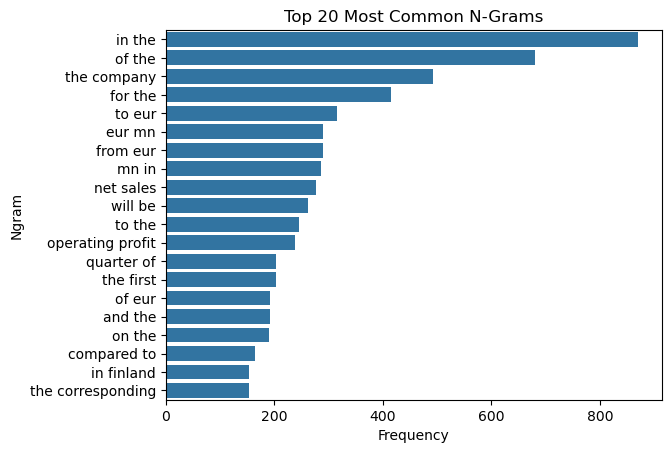

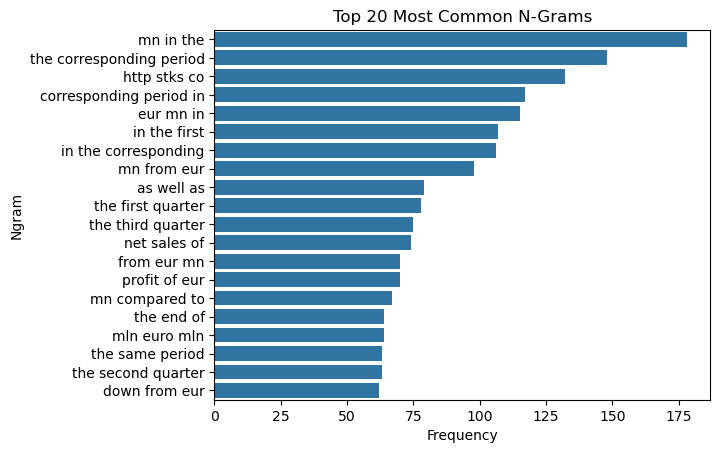

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_ngrams(corpus, ngram_range=(2, 2), top_n=20):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    common_words = words_freq[:top_n]

    df_ngram = pd.DataFrame(common_words, columns=['Ngram', 'Frequency'])
    sns.barplot(x='Frequency', y='Ngram', data=df_ngram)
    plt.title(f'Top {top_n} Most Common N-Grams')
    plt.show()

plot_ngrams(df['Sentence'], ngram_range=(2, 2))  # For bigrams
plot_ngrams(df['Sentence'], ngram_range=(3, 3))  # For trigrams

### Text Vectorization

In [17]:
# Use lemmatized text for TF-IDF vectorization
df['processed_text'] = df['lemmas'].apply(lambda x: ' '.join(x))

# Vectorize the preprocessed text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_text'])

In [18]:
X

<5836x10710 sparse matrix of type '<class 'numpy.float64'>'
	with 69105 stored elements in Compressed Sparse Row format>

In [19]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Model Building

In [20]:
smote = SMOTE(random_state=42) # SMOTE for handling class imbalance
X_resampled, y_resampled = smote.fit_resample(X, df['Sentiment'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [22]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

gcv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
gcv.fit(X_train, y_train)

# Best model
model = gcv.best_estimator_
y_pred = model.predict(X_test)

### Model Evaluation

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.81      0.84      0.83       623
     neutral       0.74      0.78      0.76       642
    positive       0.91      0.82      0.86       610

    accuracy                           0.81      1875
   macro avg       0.82      0.82      0.82      1875
weighted avg       0.82      0.81      0.82      1875



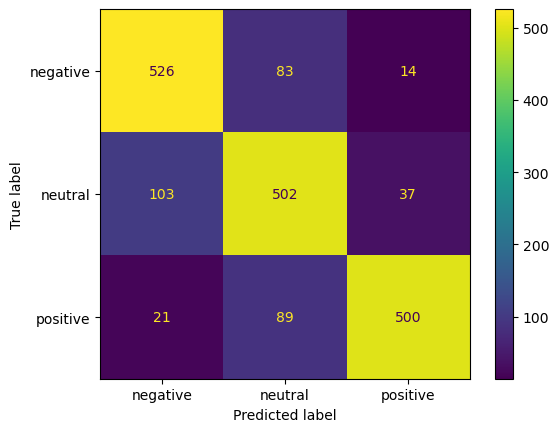

In [24]:
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred))

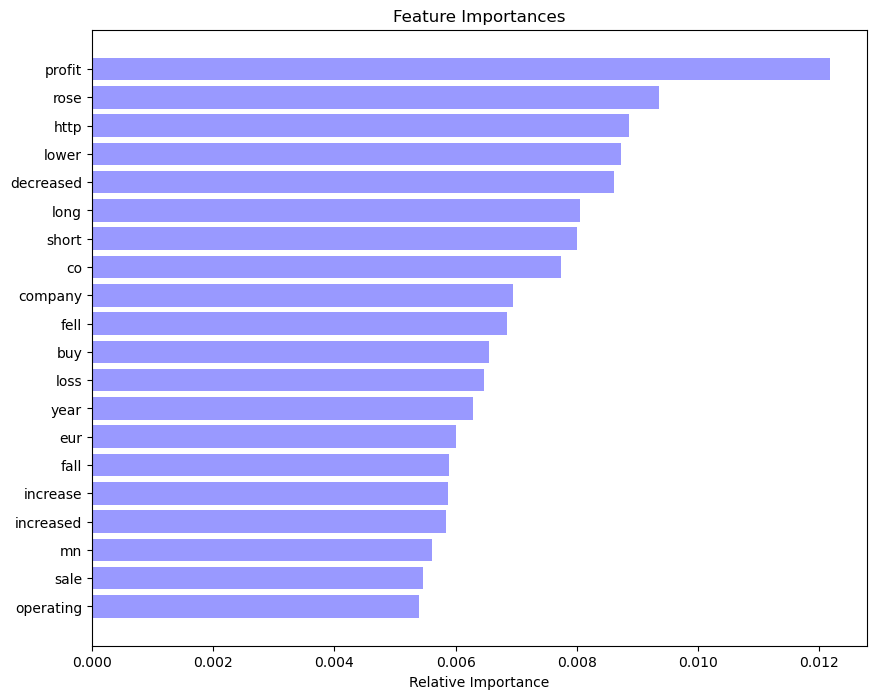

In [25]:
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[-20:]  # Top 20 features
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center', alpha=0.4)
plt.yticks(range(len(indices)), [vectorizer.get_feature_names_out()[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()